In [19]:
import torch
import torch.nn as nn
import pandas as pd
from dataset import HddSmartDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [2]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, shuffle=True)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


In [3]:
dataset = HddSmartDataset(use_mfg=True, use_normalized=True, use_raw=False)
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
print(datasets['train'][0][1].shape[0])

   smart_1_normalized  smart_2_normalized  smart_3_normalized  \
0                0.68                 0.0                0.92   
1                1.17                 0.0                0.92   
2                0.83                 0.0                0.92   
3                1.00                 1.0                1.00   
4                0.82                 0.0                0.89   

   smart_4_normalized  smart_5_normalized  smart_7_normalized  \
0                 1.0                 1.0                0.91   
1                 1.0                 1.0                0.89   
2                 1.0                 1.0                0.94   
3                 1.0                 1.0                1.00   
4                 1.0                 1.0                0.91   

   smart_8_normalized  smart_9_normalized  smart_10_normalized  \
0                 0.0                0.75                  1.0   
1                 0.0                0.58                  1.0   
2                 0.

In [4]:
class Classifier(nn.Module):

    def __init__(self, lr = 0.01):
        super().__init__()

        self.lr = lr
        if 1:
            self.model = nn.Sequential(
                nn.Linear(datasets['train'][0][1].shape[0], 100),
                nn.LeakyReLU(0.02),
                nn.Linear(100, 200),
                nn.LeakyReLU(0.02),
                nn.Linear(200,2),
                nn.Sigmoid(),
            )
        
        self.loss_funciton = nn.CrossEntropyLoss()
        #self.loss_funciton = nn.MSELoss()

        #self.optimiser = torch.optim.SGD(self.parameters(), lr = self.lr)
        self.optimiser = torch.optim.Adam(self.parameters())

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    
    def train(self, inputs, targets):

        outputs = self.forward(inputs)

        loss = self.loss_funciton(outputs, targets)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            pass

        if self.counter % 10000 == 0:
            print(f"counter = {self.counter}")
            pass

    def plot_progress(self):

        df = pd.DataFrame(self.progress, columns=['loss'])
        #df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
        df.plot(ylim=(0,1.0), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))



epoch 0


100%|██████████| 5680/5680 [00:44<00:00, 126.87it/s]


epoch 1


 76%|███████▋  | 4343/5680 [00:33<00:10, 133.12it/s]

counter = 10000


100%|██████████| 5680/5680 [00:43<00:00, 129.68it/s]


epoch 2


100%|██████████| 5680/5680 [00:43<00:00, 130.02it/s]


epoch 3


 52%|█████▏    | 2975/5680 [00:22<00:20, 129.74it/s]

counter = 20000


100%|██████████| 5680/5680 [00:43<00:00, 130.42it/s]


epoch 4


100%|██████████| 5680/5680 [00:43<00:00, 130.14it/s]


epoch 5


 28%|██▊       | 1618/5680 [00:12<00:31, 130.99it/s]

counter = 30000


100%|██████████| 5680/5680 [00:43<00:00, 131.38it/s]


epoch 6


100%|██████████| 5680/5680 [00:43<00:00, 131.46it/s]


epoch 7


  5%|▍         | 264/5680 [00:02<00:41, 129.87it/s]

counter = 40000


100%|██████████| 5680/5680 [00:43<00:00, 130.15it/s]


epoch 8


 81%|████████  | 4576/5680 [00:34<00:08, 133.37it/s]

counter = 50000


100%|██████████| 5680/5680 [00:43<00:00, 131.49it/s]


epoch 9


100%|██████████| 5680/5680 [00:48<00:00, 118.14it/s]


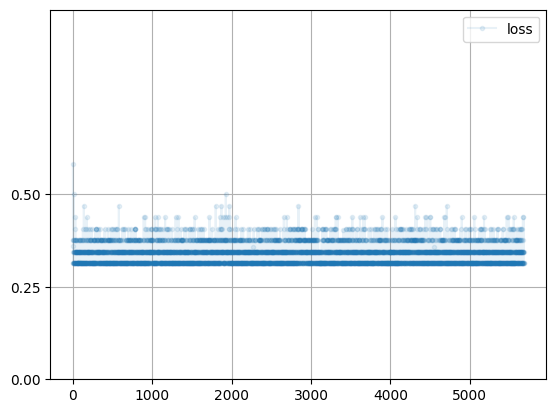

In [5]:
C = Classifier(lr = 0.1).to(device)
loader = DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True)
n_epochs = 10
for epoch in range(n_epochs):
    print(f"epoch {epoch}")
    for label, image_tensor, target_tensor in tqdm(loader):
        C.train(image_tensor.to(device), targets=target_tensor.to(device))
C.plot_progress()

0 tensor([1.0000e+00, 8.0982e-24], device='mps:0')


/Users/lion397/homebrew/Caskroom/miniforge/base/envs/ecs273/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


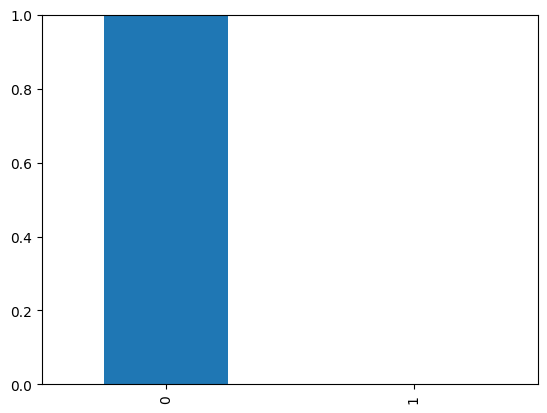

In [6]:
test_dataset = dataset
gt, img_tensor, _ = test_dataset[7000]
with torch.no_grad():
    output = C.forward(img_tensor.to(device))
pd.DataFrame(output.cpu().numpy()).plot(kind='bar', legend=False, ylim=(0,1))
print(gt,output)


In [7]:
score = 0
items = 0
test_dataset = datasets["val"]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
for labels, image_data_tensor, target_tensor in tqdm(test_loader):
    with torch.no_grad():
        answers = C.forward(image_data_tensor.to(device)).cpu().numpy()
        for answer, label in zip(answers,labels):
            if answer.argmax() == label:
            #if answer.argmax() == 0:
            #if 0 == label:
                score += 1
                pass
            items += 1


print(score, items, score/items)

100%|██████████| 947/947 [00:05<00:00, 162.52it/s]

58939 60584 0.9728476165324178


Using cache found in /Users/lion397/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


epoch 0


100%|██████████| 2840/2840 [00:33<00:00, 85.70it/s]


epoch 1


100%|██████████| 2840/2840 [00:32<00:00, 86.45it/s]


epoch 2


100%|██████████| 2840/2840 [00:32<00:00, 87.10it/s]


epoch 3


 53%|█████▎    | 1494/2840 [00:17<00:15, 86.25it/s]

counter = 10000


100%|██████████| 2840/2840 [00:32<00:00, 87.24it/s]


epoch 4


100%|██████████| 2840/2840 [00:32<00:00, 87.37it/s]


epoch 5


100%|██████████| 2840/2840 [00:33<00:00, 83.77it/s]


epoch 6


100%|██████████| 2840/2840 [00:33<00:00, 85.00it/s]


epoch 7


  5%|▍         | 135/2840 [00:01<00:31, 84.86it/s]

counter = 20000


100%|██████████| 2840/2840 [00:33<00:00, 85.68it/s]


epoch 8


100%|██████████| 2840/2840 [00:33<00:00, 84.99it/s]


epoch 9


100%|██████████| 2840/2840 [00:33<00:00, 85.09it/s]


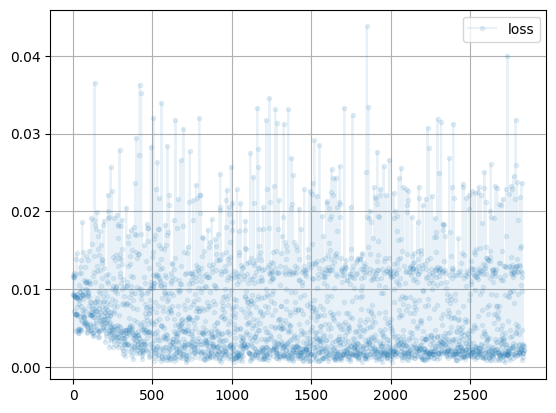

In [44]:
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input,dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

class Classifier(nn.Module):

    def __init__(self, n_input, lr = 0.01):
        super().__init__()

        self.lr = lr
        if 1:
            self.model = nn.Sequential(
                nn.Linear(n_input, 400),
                nn.LeakyReLU(0.02),
                nn.Linear(400, 200),
                nn.LeakyReLU(0.02),
                nn.Linear(200,2),
                nn.Sigmoid(),
            )
        
        if 0:
            self.loss_funciton = nn.CrossEntropyLoss()
            #self.loss_funciton = nn.MSELoss()
        else:
            focal_loss = torch.hub.load(
                        'adeelh/pytorch-multi-class-focal-loss',
                        model='FocalLoss',
                        # alpha=torch.tensor([0.02,0.98]), # Weight
                        alpha=torch.tensor([0.025,0.975]), # Weight
                        gamma=2,
                        reduction='mean',
                        force_reload=False
                    )
            #self.loss_funciton = FocalLoss(gamma=2,alpha=0.98)
            self.loss_funciton = focal_loss

        self.optimiser = torch.optim.SGD(self.parameters(), lr = self.lr)
        #self.optimiser = torch.optim.Adam(self.parameters())

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    
    def train(self, inputs, targets):

        outputs = self.forward(inputs)
    
        loss = self.loss_funciton(outputs, targets)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            pass

        if self.counter % 10000 == 0:
            print(f"counter = {self.counter}")
            pass

    def plot_progress(self):

        df = pd.DataFrame(self.progress, columns=['loss'])
        #df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
        #df.plot(ylim=(0,1.0), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
        df.plot(alpha=0.1, marker='.', grid=True)

C = Classifier(n_input=datasets['train'][0][1].shape[0],lr = 0.01).to(device)
loader = DataLoader(dataset=datasets['train'], batch_size=64, shuffle=True)
n_epochs = 10
for epoch in range(n_epochs):
    print(f"epoch {epoch}")
    for label, image_tensor, target_tensor in tqdm(loader):
        #C.train(image_tensor.to(device), targets=target_tensor.to(device))
        C.train(image_tensor.to(device), targets=label.to(device))
C.plot_progress()

In [48]:
score = np.zeros(2)
miss_score = np.zeros(2)
items = np.zeros(2)
Y_test = []
yPred = []
test_dataset = datasets["val"]
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
for labels, image_data_tensor, target_tensor in tqdm(test_loader):
    with torch.no_grad():
        answers = C.forward(image_data_tensor.to(device)).cpu().numpy()
        for answer, label in zip(answers,labels):
            Y_test.append(label)
            yPred.append(answer.argmax())
            if answer.argmax() == label:
            #if answer.argmax() == 0:
            #if 0 == label:
                score[label] += 1
                pass
            else:
                miss_score[label] += 1
            items[label] += 1


print("correct",score, items, score/items)
print("incorrect",miss_score, items, miss_score/items)

100%|██████████| 119/119 [00:05<00:00, 20.01it/s]

correct [52728.  1274.] [58893.  1691.] [0.89531863 0.75340035]
incorrect [6165.  417.] [58893.  1691.] [0.10468137 0.24659965]


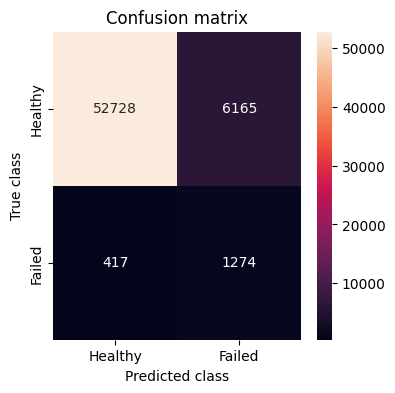

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
 # confusion matrix 
LABELS = ['Healthy', 'Failed'] 
conf_matrix = confusion_matrix(Y_test, yPred) 
plt.figure(figsize =(4, 4)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 